In [15]:
from pyproj import Transformer

wgs84_proj = "epsg:4326"
aea_proj = "epsg:3577"
wm_proj = "epsg:3857"



([inf], [inf])

In [42]:
#https://australia-southeast1-wald-1526877012527.cloudfunctions.net/tree-change?service=WMS&request=GetMap&layers=wcf&styles=&format=image%2Fpng&transparent=true&version=1.1.1&time=2020-01-01T00%3A00%3A00.000Z&width=256&height=256&srs=EPSG%3A3857&bbox=16591115.61146722,-4204648.051910976,16593561.596372345,-4202202.06700585

bbox = [16600899.551087722,-4207094.0368161,16603345.535992848,-4204648.051910976]

transformer = Transformer.from_crs(wm_proj, wgs84_proj)
ys, xs = transformer.transform([bbox[0],bbox[2]], [bbox[1],bbox[3]])

ys, xs

([-35.31736632923786, -35.29943548054544], [149.12841796875003, 149.150390625])

In [43]:
transformer = Transformer.from_crs(wm_proj, aea_proj)
ys, xs = transformer.transform([bbox[0],bbox[2]], [bbox[1],bbox[3]])

ys, xs

([1549873.016040405, 1552116.0559155752],
 [-3961466.066650687, -3959757.440165286])

In [67]:
import xarray as xr

i,j = 4,7
fname = f"/data/pca_act/{26*i+j:03d}_2018.nc"
print(fname)
ds = xr.open_dataset(fname)

ds.x

#000   1506645  1510635    001    1506645  1510635    026   1510645  1514635
#     -3932965 -3936955          -3936965 -3940955         -3932965 -3936955

def geotransform(i,j):
    return (1506645+i*4000,10,0,-3932965-j*4000,0,-10)

def tiles(x,y):
    return int((x-1506645)/4000.), int((-3932965-y)/4000.)

def bbox2tiles(bbox):
    transformer = Transformer.from_crs(wm_proj, aea_proj)
    xs, ys = transformer.transform([bbox[0],bbox[2]], [bbox[3],bbox[1]])

    i0,j0=tiles(xs[0],ys[0])
    i1,j1=tiles(xs[1],ys[1])
    return (i0,i1,j0,j1)

bbox=[16600899.551087722,-4207094.0368161,16603345.535992848,-4204648.051910976]


geotransform(i,j), ds.x[100].values, ds.y[100].values, tiles(1523645,-3961965),bbox2tiles(bbox)

/data/pca_act/111_2018.nc


((1522645, 10, 0, -3960965, 0, -10),
 array(1523645.),
 array(-3961965.),
 (4, 7),
 (10, 11, 6, 7))

11 12 5 6
11 5
11 6
12 5
12 6


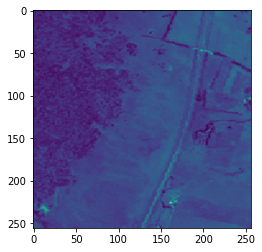

In [123]:
import numpy as np
from matplotlib import pyplot as plt


#bbox=[16600899.551087722,-4207094.0368161,16603345.535992848,-4204648.051910976]
bbox=[16605791.520897973,-4202202.06700585,16608237.505803099,-4199756.082100724]
i0,i1,j0,j1 = bbox2tiles(bbox)

im_size = 256

pixel_size = ((bbox[2] - bbox[0]) / im_size, (bbox[3] - bbox[1]) / im_size)
    
tile_xs = np.arange(bbox[0], bbox[2], pixel_size[0])
tile_ys = np.arange(bbox[3], bbox[1], -pixel_size[1])
 
transformer = Transformer.from_crs(wm_proj, aea_proj)
aea_xs, aea_ys = transformer.transform(tile_xs, tile_ys)

arr = np.zeros((im_size,im_size), dtype=np.float32)
for i in range(i0, i1+1):
    for j in range(j0, j1+1):
        print(i, j)
        fname = f"/data/pca_act/{26*i+j:03d}_2018.nc"
        im = xr.open_dataset(fname).nbart_blue.isel(time=2).values/1e4
        geot = geotransform(i,j)

        vi = np.round((aea_xs - geot[0]) / geot[1]).astype(np.int64)
        vi[(vi>399) | (vi<0)] = -1
        vj = np.round((aea_ys - geot[3]) / geot[5]).astype(np.int64)
        vj[(vj>399) | (vj<0)] = -1

        for pj in range(im_size):
            for pi in range(im_size):
                if vi[pi] < 0 or vj[pj] < 0:
                    continue
                arr[pj,pi] = im[vj[pj],vi[pi]]
            
            
plt.imshow(arr)

In [75]:
lons = np.arange(bbox[0], bbox[2], pixel_size[0])
lons[0],lons[-1]

(16600899.551087722, 16603335.981364429)

In [94]:
%matplotlib inline

i,j = 11,6
fname = f"/data/pca_act/{26*i+j:03d}_2018.nc"
print(fname)
ds = xr.open_dataset(fname)

ds.y.values[0], ds.x.values[0], geotransform(11,6)

/data/pca_act/292_2018.nc


(-3956965.0, 1550645.0, (1550645, 10, 0, -3956965, 0, -10))